In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import layers

# Convolutional Neural Networks

In the convolutional layer, the neurons are not connected to every part of the input data.
The anatomy of a Convolutional layer.

A dense layer learns global patterns. A convolution layer learns local patterns. Because of that, CNNs are **translation invariant** as they pick part of the image of time series and generalize the learning elsewhere. CNNs learn **hierarchical patterns**: a first layer learns a local pattern, a second layer combines the local features to create a broader scale feature.


<img src="Convolution.png" alt="cnn" style="width: 400px;"/>

* The **input** "feature map" is the input data for a given layer. It is 3D for a 2D convolution. The three dimensions are: *height*, *width*, *depth/channels*. For instance, width and heights are the 2D images, the depth can be the different RGB. The ordering of the dimension of the input is captured in the ``data_format`` argument with ``'channel_first'`` 
 When including 3D data (RGB of images, or multi channels of geophysical measurement's spectrograms), write out the input shape: batch_shape + (channels, rows, cols) if ``data_format='channels_first'`` or batch_shape + (rows, cols, channels) if ``data_format='channels_last'``.
* The **filters** are the **convolution kernels** are the dimensionality of the output space. 
* The **kernel size** is a list of 2 integer that specifies the height and width of the 2D convolution window. If both integers are equal, just use a single integer value.
* The **stride** is the step that the convolution skips when being applying the filters. It is one way to reduce the feature map, but the most popular choice for this is to use ***maxpooling***.
* The **padding** is set to either ``SAME`` or ``VALID`` depending on whether the edges of the feature map are extended and filled with zeros (same) to fit the total length of the kernel size and stride, or wether they are ignored (valid)

The convolution can be 1D or 2D depending on the array input:

When the input a single dimension array (vector, time series), use a Conv1D layer.
https://keras.io/api/layers/convolution_layers/convolution1d/


When the input is a 2D image (2D array) or a time series with multiple channels (example of a seismogram with 3 components), use Conv2D layers.
https://keras.io/api/layers/convolution_layers/convolution2d/

A neuron weight can be represented as a small image the size of the receiptive field. It reduces the dimensionality of the image.

Stride is the shift over features
Input_shape is the dimension of the data.


## Pooling layers

**MaxPooling** layers are downsampling layers. It ouputs the max value of each channel of windwos in a feature map. Downsampling reduces the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of
the original input they cover). The pooling size is the factor of reduction in the layer size.

**UpSampling**
One can do the opposite and upsample the data using interpolation, either the nearest value or a bilinear interpolation. This will be used later for auto-encoders.




In [55]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
class_names = ["tshirt","trousers","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
X_val,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_val,y_train = y_train_full[:5000],y_train_full[5000:]
# Here we have to add one dimension to the images in order to match the conv2D requirements in Keras.
# And we do it for all variables.
X_train=X_train[...,None]
X_val=X_val[...,None]
X_test=X_test[...,None]
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))
print(len(np.unique(y_train)))

(55000, 28, 28, 1)
(55000,)
[0 1 2 3 4 5 6 7 8 9]
10


### Create the model

In [47]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(layers.Conv2D(filters=64, kernel_size=7, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(layers.MaxPooling2D(2))
# model.add(tf.keras.layers.Dropout(0.3))
# it is common practice to double the number of filters after each pooling layer since we just rediced the number of parameters and we can afford it
model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')) 
model.add(layers.MaxPooling2D(2))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

### Compile the model
choose the appropriate loss function. We have a multi-class classification example, so we will use the categorical crossentropy. We will use the Adam optimizer to be fast. We will use the accuracy for the metric on the loss.

In [48]:
cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", # use the validation loss as a metric
    patience=2, # number of epochs to wait until there is improvement
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer='adam',
             metrics="accuracy",callbacks=cb)

### Train the model
Choose the batch size, the number of epochs (iterations). Fit and be patient: grab a coffee, watch a webinar.

In [57]:
history = model.fit(X_train,
         y_train,
          batch_size=24,
         epochs=20,
         validation_data=(X_val,y_val))

Epoch 1/20
2292/2292 [==============================] - 111s 48ms/step - loss: 0.1697 - accuracy: 0.9421 - val_loss: 0.2827 - val_accuracy: 0.9236
Epoch 2/20
2292/2292 [==============================] - 109s 48ms/step - loss: 0.1708 - accuracy: 0.9425 - val_loss: 0.2763 - val_accuracy: 0.9180
Epoch 3/20
2292/2292 [==============================] - 115s 50ms/step - loss: 0.1622 - accuracy: 0.9453 - val_loss: 0.2924 - val_accuracy: 0.9220
Epoch 4/20
2292/2292 [==============================] - 108s 47ms/step - loss: 0.1630 - accuracy: 0.9453 - val_loss: 0.2783 - val_accuracy: 0.9160
Epoch 5/20
2292/2292 [==============================] - 111s 48ms/step - loss: 0.1652 - accuracy: 0.9448 - val_loss: 0.2926 - val_accuracy: 0.9214
Epoch 6/20
2292/2292 [==============================] - 113s 49ms/step - loss: 0.1545 - accuracy: 0.9476 - val_loss: 0.2839 - val_accuracy: 0.9208
Epoch 7/20
2292/2292 [==============================] - 118s 51ms/step - loss: 0.1620 - accuracy: 0.9457 - val_loss: 0

### Evaluate the model
Plot the acuracy scores as a function of epochs to see how well we train. Note that we used the ``callbacks`` option to stop after a few iterations if there was no more improvememnts

313/313 [==============================] - 9s 29ms/step - loss: 145.5478 - accuracy: 0.8781

 Test accuracy: 0.8780999779701233


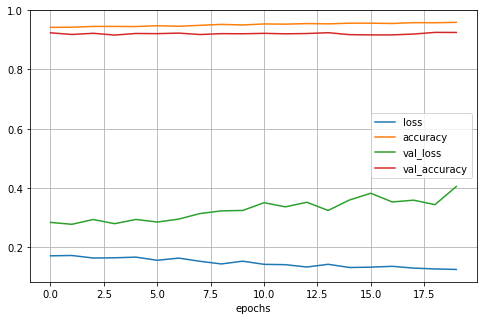

In [58]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epochs')

# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=1)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])



## Example on seismic data

In this class, we will use a simplified version of ConvNetQuake (Perol et al, 2018). We will use the two seismic station seismograms already labeled as "earthquakes" or "noise" to perform.


<img src="fig2.jpg" alt="ConvNetQuake" style="width: 400px;"/>


### 1. read the data

In [59]:
# load OK029 template data:
with h5py.File("./data/templates_029.h5", "r") as f:
    eq1 = np.asarray(f['earthquakes']);neq1=eq1.shape[0]
    no1 = np.asarray(f["noise"])


# load OK027 template data:
with h5py.File("./data/templates_027.h5", "r") as f:
    eq2 = np.asarray(f['earthquakes'])
    no2 = np.asarray(f["noise"])

### 2. Prep data

In [60]:
#  allocate memory
quakes=np.zeros(shape=(eq1.shape[0],1000,3),dtype=np.float32)
noise=np.zeros(shape=(no1.shape[0],1000,3),dtype=np.float32)
quakes2=np.zeros(shape=(eq2.shape[0],1000,3),dtype=np.float32)
noise2=np.zeros(shape=(no2.shape[0],1000,3),dtype=np.float32)

# Normalize the seismograms to their peak amplitudes
for iq in range(quakes.shape[0]):
    for ic in range(3):
        if np.max(np.abs(crap1[iq,ic,:]))>0:
            quakes[iq,:,ic]=crap1[iq,ic,:]/np.max(np.abs(crap1[iq,ic,:]))
        if np.max(np.abs(crap2[iq,ic,:]))>0:
            noise[iq,:,ic]=crap2[iq,ic,:]/np.max(np.abs(crap2[iq,ic,:]))

for iq in range(len(crap1[:,1,1])):
    for ic in range(3):
        if np.max(np.abs(crap1[iq,ic,:]))>0:
            quakes2[iq,:,ic]=crap1[iq,ic,:]/np.max(np.abs(crap1[iq,ic,:]))
        if np.max(np.abs(crap2[iq,ic,:]))>0:
            noise2[iq,:,ic]=crap2[iq,ic,:]/np.max(np.abs(crap2[iq,ic,:]))
            
# select data that is strictly positive and finite
iq1=np.where( ( np.abs(quakes[:,0,0])>0)&(np.isfinite(quakes[:,0,0])))[0]
iq2=np.where( (np.abs(quakes2[:,0,0])>0)&(np.isfinite(quakes2[:,0,0])))[0]

NameError: name 'crap1' is not defined

In [ ]:
# label & data
y = np.concatenate((np.ones(len(iq1)+len(iq2),dtype=np.int),np.zeros(len(iq1)+len(iq2),dtype=np.int))) # 0 for noise, 1 for event
# X = np.zeros(shape=(len(train_labels),1000,3,1))
X= np.concatenate((quakes[iq1,:,:],quakes2[iq2,:,:],noise[iq1,:,:],noise2[iq2,:,:]),axis=0)
X=X[...,None]# add that depth/channel dimension

nlabels=2 # = len(np.unique(y))

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### 3 Define ML model

In [ ]:
l2 = 1E-4 # L2 norm regularization

# building the architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1000,3,1), use_bias=True, strides=(2,2), kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=(2,2), kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Flatten())
model.add(layers.Dense(nlabels, activation='softmax'))

In [ ]:
# compile the network
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# training
history=model.fit(X_train,y_train,validation_split=0.2, epochs=20, batch_size=128,shuffle=True) 


In [ ]:
# check for overfitting
history_dic = history.history
loss_values = history_dic['loss']
val_loss_values = history_dic['val_loss']
acc_values = history_dic['acc']
val_acc_values = history_dic['val_acc']
epochs=range(1,len(loss_values)+1)
fig,ax=plt.subplots(2)
ax[0].plot(epochs,loss_values,'bo',label='Training loss')
ax[0].plot(epochs,val_loss_values,'b',label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs,acc_values,'bo',label='Training accuracy')
ax[1].plot(epochs,val_acc_values,'b',label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()


In [ ]:
# testing
test=model.evaluate(X_test,y_test,batch_size=64,verbose=1)
print('loss and accuracy at test')
print(test)

## Tuning CNN networks

There are many hyperparameters and model choices to make:
* learning rate, optimizer, batch_size, activation functions, loss functions
* architecture: number of layers, depth of kernels, activation functions, regularization, batch normalization

One can treat the hyperparameter search as an optimization problem. Keras tuner (https://keras-team.github.io/keras-tuner/) can be used to randomize the grid search.